<a href="https://colab.research.google.com/github/Atfssene/FRASA/blob/main/Regression_Model_FRASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summarization Model

In this notebook, we will create a model for text summarization task. From previous EDA, we know they're correlation between features/columns.

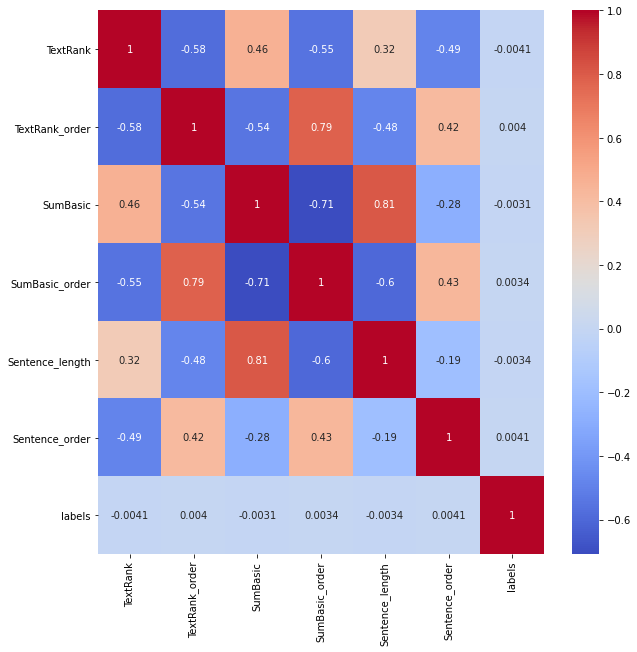

## Import library

In [321]:
# Import library
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from sklearn import preprocessing as sk_preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score,roc_curve

# Repository URL
url = "https://raw.githubusercontent.com/Atfssene/FRASA/main/Text%20Summarization/"

## Read data

In [133]:
list_columns = {'TextRank':eval,'TextRank_order':eval,'SumBasic':eval,'SumBasic_order':eval, 'Sentence_length':eval,'Sentence_order':eval, 'labels':eval,}

train_df = pd.read_csv(url+'/extracted_train.csv', converters=list_columns)
test_df = pd.read_csv(url+'/extracted_test.csv', converters=list_columns)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TextRank         15012 non-null  object
 1   TextRank_order   15012 non-null  object
 2   SumBasic         15012 non-null  object
 3   SumBasic_order   15012 non-null  object
 4   Sentence_length  15012 non-null  object
 5   Sentence_order   15012 non-null  object
 6   labels           15012 non-null  object
dtypes: object(7)
memory usage: 821.1+ KB


Before we flatten the data, we need to normalizing the list of TextRank and SumBasic because both are paragraph based value.

In [134]:
def normalization(list_weight):
  norm = np.array(list_weight)
  norm = norm.reshape(1,-1)
  norm = sk_preprocessing.normalize(norm)
  norm = [item for sublist in norm for item in sublist]
  return norm

normalized = ['TextRank', 'SumBasic']
for norm in normalized:
  train_df[norm] = train_df.apply(lambda row: normalization(row[norm]), axis=1)
  test_df[norm] = test_df.apply(lambda row: normalization(row[norm]), axis=1)

## Flatten data

In [142]:
flat_train = pd.DataFrame()
flat_test =  pd.DataFrame()
for column in train_df.columns:
  flat_train[column] = pd.to_numeric(train_df.explode(column, ignore_index=True)[column])
  flat_test[column] = pd.to_numeric(test_df.explode(column, ignore_index=True)[column])
flat_train

,TextRank,TextRank_order,SumBasic,SumBasic_order,Sentence_length,Sentence_order,labels
0,0.242559,7,4.162398e-01,1,15,1,0
1,0.254988,2,3.441983e-01,4,15,2,1
2,0.256001,1,3.602075e-01,2,15,3,1
3,0.220594,15,1.761015e-01,12,9,4,1
4,0.247298,4,9.605534e-02,17,7,5,0
...,...,...,...,...,...,...,...
268914,0.208422,2,3.075074e-01,3,21,24,0
268915,0.194041,15,1.590555e-01,15,9,25,0
268916,0.203506,6,2.438852e-01,5,14,26,0
268917,0.189631,16,4.771666e-02,25,6,27,0


In [143]:
flat_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TextRank,268919.0,0.228448,0.060291,1.796035e-02,0.194026,0.227848,0.263157,1.0
TextRank_order,268919.0,11.130604,8.124076,1.000000e+00,5.000000,10.000000,15.000000,76.0
SumBasic,268919.0,0.202896,0.121066,3.016877e-09,0.114266,0.188788,0.274695,1.0
SumBasic_order,268919.0,11.130604,8.124076,1.000000e+00,5.000000,10.000000,15.000000,76.0
Sentence_length,268919.0,10.995839,6.127034,0.000000e+00,7.000000,10.000000,14.000000,187.0
Sentence_order,268919.0,11.130604,8.124076,1.000000e+00,5.000000,10.000000,15.000000,76.0
labels,268919.0,0.186844,0.389787,0.000000e+00,0.000000,0.000000,0.000000,1.0


No empty values. Great!

Let's see flatten data in a graph

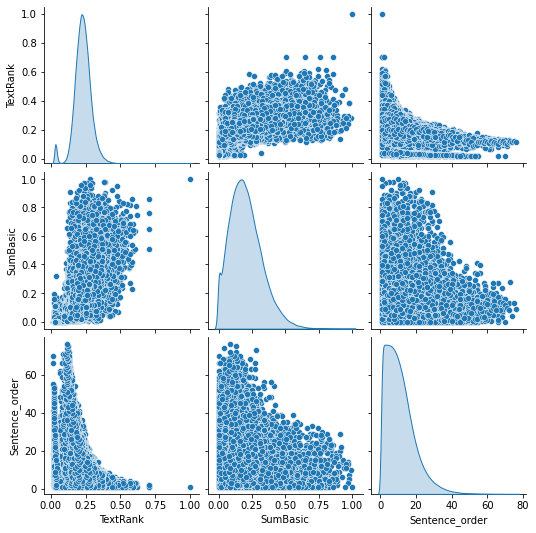

In [144]:
sns.pairplot(flat_train.sample(300)[['TextRank', 'SumBasic', 'Sentence_order']], diag_kind='kde')

We can see outliers here, let's remove them.

We will cutoff the 

In [145]:
data = flat_train['TextRank']
data_mean, data_std = data.mean(axis=0), data.std(axis=0)
# This is use 4x standar deviation to identify outliers
cut_off = data_std * 4
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in data if x < lower or x > upper]

print(lower, upper)
flat_train = flat_train[~flat_train.TextRank.isin(outliers)]

-0.012714398480096173 0.46961068250983484


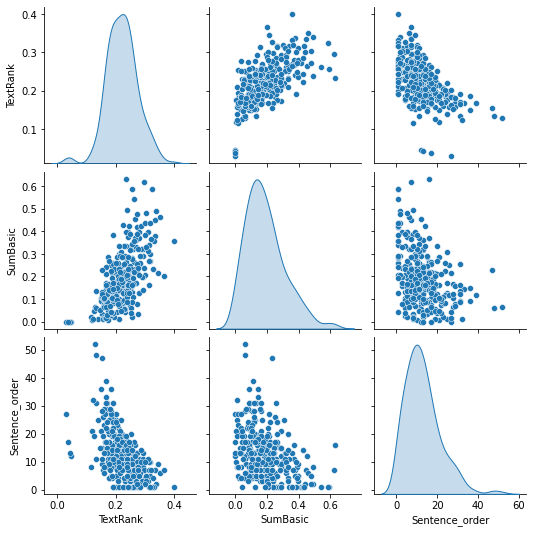

In [149]:
sns.pairplot(flat_train.sample(300)[['TextRank', 'SumBasic', 'Sentence_order']], diag_kind='kde')

## Split features and target

In [337]:
target = "TextRank"
features=['SumBasic', 'SumBasic_order', 'Sentence_length', 'Sentence_order']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 4), (66659, 4), (268658,), (66659,))

# Create Model #1

## Normalization Layer

Function to build and compile model with normalization layer

In [281]:
def create_model(x_train):
  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(np.array(x_train))
  model = keras.Sequential([
      norm_layer,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

Function to plotting loss

In [230]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

## DNN Layer

In [231]:
model = create_model(x_train)
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_22 (Normalizat (None, 4)                 9         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 129       
Total params: 17,290
Trainable params: 17,281
Non-trainable params: 9
_________________________________________________________________


## Callback

In [223]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## Train layer

In [232]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.001,
    verbose=2,
    epochs=100,
    callbacks = [callbacks])

Epoch 1/100
8388/8388 - 9s - loss: 0.0270 - val_loss: 0.0219
Epoch 2/100
8388/8388 - 8s - loss: 0.0237 - val_loss: 0.0211
Epoch 3/100
8388/8388 - 8s - loss: 0.0232 - val_loss: 0.0211
Epoch 4/100
8388/8388 - 8s - loss: 0.0230 - val_loss: 0.0214
Epoch 5/100
8388/8388 - 8s - loss: 0.0229 - val_loss: 0.0214
Epoch 6/100
8388/8388 - 8s - loss: 0.0228 - val_loss: 0.0219
Epoch 7/100
8388/8388 - 9s - loss: 0.0227 - val_loss: 0.0206
Epoch 8/100
8388/8388 - 8s - loss: 0.0226 - val_loss: 0.0211
Epoch 9/100
8388/8388 - 8s - loss: 0.0225 - val_loss: 0.0206
Epoch 10/100
8388/8388 - 9s - loss: 0.0225 - val_loss: 0.0210
Epoch 11/100
8388/8388 - 9s - loss: 0.0224 - val_loss: 0.0211
Epoch 12/100
8388/8388 - 8s - loss: 0.0224 - val_loss: 0.0208
Epoch 00012: early stopping


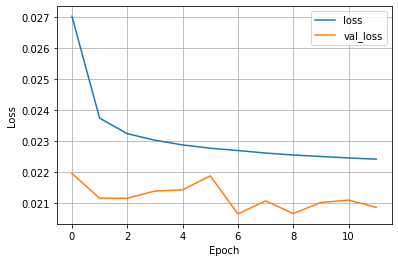

In [236]:
plot_loss(history)

## Evaluate result #1

Save the result to compare later

In [ ]:
evaluate_result = {}

In [233]:
evaluate_result['4 features'] = model.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 933us/step - loss: 0.0222


In [258]:
test_predictions = model.predict(x_test).flatten()
for t in range(1,10):
  print(test_predictions[t], y_test[t])

0.26368597 0.24572682221837625
0.22923881 0.24018587818720966
0.25682968 0.2468131652371983
0.2409297 0.2436909275562206
0.22492884 0.23186550023376296
0.234752 0.23259516712618628
0.206456 0.2219968816220938
0.21276757 0.2374203618123999
0.24122792 0.22470100601433482


In [235]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
4 features,0.022207
2 features,0.032362
1 features,0.032542


# Create Model #2

Let's try again but with more selected features.

In [279]:
target = "TextRank"
features=['SumBasic', 'Sentence_length']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 2), (66659, 2), (268658,), (66659,))

In [ ]:
second_model = create_model(x_train)
second_model.summary()

history = second_model.fit(
    x_train,
    y_train,
    validation_split=0.01,
    verbose=2,
    epochs=100,
    callbacks = [callbacks])

plot_loss(history)

## Evaluate result #2

Save the result to compare later

In [172]:
evaluate_result['2 features'] = second_model.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 880us/step - loss: 0.0324


In [173]:
test_predictions = second_model.predict(x_test).flatten()
for t in range(1,10):
  print(test_predictions[t], y_test[t])

0.27146596 0.24572682221837625
0.2230433 0.24018587818720966
0.2568694 0.2468131652371983
0.24133387 0.2436909275562206
0.22199512 0.23186550023376296
0.22816584 0.23259516712618628
0.21707362 0.2219968816220938
0.21448927 0.2374203618123999
0.22084516 0.22470100601433482


In [222]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
4 features,0.022309
2 features,0.032362
1 features,0.032542


# Create Model #3

In [185]:
target = "TextRank"
features=['SumBasic']
x_train = flat_train[features].copy()
x_test = flat_test[features].copy()

y_train = flat_train[target].copy()
y_test = flat_test[target].copy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((268658, 1), (66659, 1), (268658,), (66659,))

Epoch 00012: early stopping
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


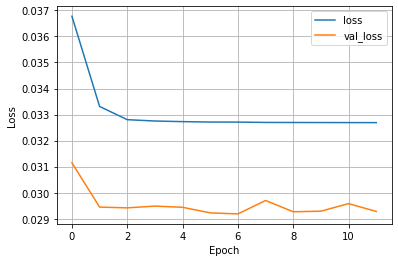

In [193]:
third_norm = preprocessing.Normalization()
third_norm.adapt(np.array(x_train))

# Remove the normalized layer because we have did in early this notebook
third_model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

third_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))

history = third_model.fit(
    x_train,
    y_train,
    validation_split=0.001,
    verbose=2,
    epochs=100,
    callbacks = [callbacks])
third_model.summary() 
plot_loss(history)

## Evaluate result #3

Save the result to compare later

In [194]:
evaluate_result['1 features'] = third_model.evaluate(x_test, y_test, verbose=1)

2084/2084 [==============================] - 2s 882us/step - loss: 0.0325


In [ ]:
test_predictions = third_model.predict(x_test).flatten()
for t in range(1,10):
  print(test_predictions[t], y_test[t]])

In [197]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
4 features,0.022214
2 features,0.032362
1 features,0.032542


# Save

It seems clear that 4 features is better, far better. So, we save the models and continue to the deployment.

In [237]:
model.save('frasa_model')
model.save('frasa_model.h5')

INFO:tensorflow:Assets written to: frasa_model/assets


In [338]:
reloaded = tf.keras.models.load_model('frasa_model')

evaluate_result['reloaded'] = reloaded.evaluate(
    x_test, y_test, verbose=0)

In [339]:
pd.DataFrame(evaluate_result, index=['Mean Absolute Error']).T

,Mean Absolute Error
4 features,0.022207
2 features,0.032362
1 features,0.032542
reloaded,0.022207
4 features+,3.285284
4 features++,3.347411
label target,0.190125


In [244]:
reloaded.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_22 (Normalizat (None, 4)                 9         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 129       
Total params: 17,290
Trainable params: 17,281
Non-trainable params: 9
_________________________________________________________________


In [342]:
test_predictions = reloaded.predict(x_test).flatten()
for t in range(1,10):
  print(round(test_predictions[t], ndigits=5), round(y_test[t],ndigits=5))

0.26369 0.24573
0.22924 0.24019
0.25683 0.24681
0.24093 0.24369
0.22493 0.23187
0.23475 0.2326
0.20646 0.222
0.21277 0.23742
0.24123 0.2247
